In [1]:
from datetime import datetime, timedelta
import os, sys

import torch
import torch.nn as nn
from torch import optim
from matplotlib import pyplot as plt
from pathlib import Path
%matplotlib inline
plt.rcParams['figure.figsize'] = [17, 4]
import seaborn as sns
import numpy as np
import pandas as pd

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from loop.optimizers.adamw import AdamW

from torches.train.loop import train
from torches.utils.sequence_dataset import SequenceDataset

from torches.models.pipeline_model import PipelineModel
from torches.modules.learners.prediction_quantile import PredictionQuantileLearner
from torches.modules.learners.ar_learner import ARLearner
from torches.modules.learners.dshw_add import DSHWAdditiveLearner
from torches.modules.learners.exog_conv import ExogConvLearner
from torches.modules.learners.one_step_lstm import OneStepLSTMLearner

from torches.utils.containers import Phase
from torches.modules.learners.base import BaseLearner, BaseStatefulContainer


from ts_eval.viz import metrics as mtx
from ts_eval.viz import time_slices
from ts_eval.viz.api import TSMetrics
from ts_eval.viz.data_containers import xr_2d_factory
from ts_eval.models.naive import snaive_pi
from ts_eval.forecast_strategy.naive import NaiveForecastStrategy, SNaiveForecastStrategy
from ts_eval.forecast_strategy.sm import SMForecastStrategy
from ts_eval.utils import create_sliding_dataset


S3_MNT_DOCKER_PATH = '/mnt/data/'
FPATH = f"{S3_MNT_DOCKER_PATH}data.pickle"


def add_nint_seasonality_indexes(df):
    """
    Add datetime features from index

    Note: we don't need year for this type of problem
    """
    df["month"] = df.index.month.astype(np.uint8)
    df["dow"] = df.index.dayofweek

    s = datetime(year=2010, month=10, day=10, hour=0, minute=0)
    time2index_seas1 = {(s + timedelta(minutes=i * 60)).time(): i for i in range(24)}
    
    it = enumerate([(wi, i) for wi in range(7) for i in range(24)])
    time2index_seas2 = {(wi,(s + timedelta(minutes=i * 60)).time()): idx for idx,(wi,i) in it }

    
    df['nint_seas1'] = df.index.map(lambda x: time2index_seas1[x.time()]) #.astype(np.uint8)
    df['nint_seas2'] = df.index.map(lambda x: time2index_seas2[(x.dayofweek, x.time())]) #.astype(np.uint8)


/opt/conda/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Data

In [2]:
ws15 = pd.read_pickle(FPATH)
ws15 = ws15.resample("1h").mean()
ws15 = (ws15-ws15.mean())/ws15.std()
add_nint_seasonality_indexes(ws15)
ws15.shape

(10297, 28)

In [3]:
ws15_train = ws15.query('index < "2019-09-15"')
ws15_test = ws15.query('index >= "2019-09-15"')

ws15_train.shape, ws15_test.shape

((8914, 28), (1383, 28))

In [4]:
PRED_COLS = ['power']
SEAS_MASK_COLS = [
    'nint_seas1', 'nint_seas2'
]
EXOG_CAT_COLS = [
    'public_holiday'
]
EXOG_CNT_COLS = [
    'temp',
]
TARGET_COLS = ['power']
LOOK_BACK = 24*7*4  # 6 in orig
MULTISTEPS = 24

SLICE_LEN = LOOK_BACK + ws15_train.shape[0]


BATCH_SIZE = 64

Wrap datasets in a convenient format:

In [5]:
ds = SequenceDataset(ws15_train, PRED_COLS, SEAS_MASK_COLS, EXOG_CAT_COLS, EXOG_CNT_COLS, TARGET_COLS, history_steps=LOOK_BACK, future_steps=MULTISTEPS)
train_dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)


ds = SequenceDataset(ws15_test, PRED_COLS, SEAS_MASK_COLS, EXOG_CAT_COLS, EXOG_CNT_COLS, TARGET_COLS, history_steps=LOOK_BACK, future_steps=MULTISTEPS)
test_dl = DataLoader(ds, batch_size=128, shuffle=False)


x0, seas_mask0, exog_cat0, exog_cnt0, y0 = next(iter(train_dl))
xt0, seas_maskt0, exog_catt0, exog_cntt0, yt0 = next(iter(test_dl))

print(x0.size(), seas_mask0.size(), exog_cat0.size(), exog_cnt0.size(), y0.size(), len(train_dl))
print(xt0.size(), seas_maskt0.size(), exog_catt0.size(), exog_cntt0.size(), yt0.size(), len(test_dl))

torch.Size([64, 672, 1]) torch.Size([64, 696, 2]) torch.Size([64, 696, 1]) torch.Size([64, 696, 1]) torch.Size([64, 24, 1]) 129
torch.Size([128, 672, 1]) torch.Size([128, 696, 2]) torch.Size([128, 696, 1]) torch.Size([128, 696, 1]) torch.Size([128, 24, 1]) 6


# Model

In [6]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.zeros_(m.weight)
    elif isinstance(m, nn.LSTMCell):
        nn.init.xavier_uniform_(m.weight_ih.data)
        nn.init.orthogonal_(m.weight_hh.data)
#         nn.init.constant_(m.bias_ih.data, 0)
#         nn.init.constant_(m.bias_hh.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data, 0)  # for dense learner
#         nn.init.xavier_uniform_(m.weight.data)
#         nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Embedding):
        nn.init.uniform_(m.weight.data, -1.0, 1.0)
    elif isinstance(m, nn.Embedding):
        nn.init.uniform_(m.weight.data, -1.0, 1.0)
    elif isinstance(m, DSHWAdditiveLearner):
        pass
#         m.alphas.data = torch.tensor(-1.9275)
#         m.betas.data = torch.tensor(-5.5386)
#         m.gammas.data = torch.tensor(-1.9065)
#         m.omegas.data = torch.tensor(-1.5138)
#         m.alphas.requires_grad = False
#         m.betas.requires_grad = False
#         m.gammas.requires_grad = False
#         m.omegas.requires_grad = False

#         m.init_Ic.data = torch.tensor(iIc)
#         m.init_wc.data = torch.tensor(iwc)
#         m.init_Ic.data = torch.tensor(I1)
#         m.init_wc.data = torch.tensor(w1)
#     else:
#         print(m, m.__class__)
# 'pipeline.0.alphas', tensor([-1.8219])),
#              ('pipeline.0.betas', tensor([-5.1995])),
#              ('pipeline.0.gammas', tensor([-1.6952])),
#              ('pipeline.0.omegas', tensor([-1.6693])),
    
def setup_model_params(model):
    opt_conf = []
    for n, p in model.named_parameters():
#         if n in ('pipeline.1.alphas', 'pipeline.1.betas', 'pipeline.1.gammas', 'pipeline.1.omegas'):
#             params = {"params": p, "lr": 0.05, "weight_decay": 1e-4}
#         elif n in ('pipeline.2.phis',):
#             params = {"params": p, "lr": 0.05, "weight_decay": 1e-4}
#         elif n in ('pipeline.1.init_Ic', 'pipeline.1.init_wc'):
#             params = {"params": p, "lr": 0.1, "weight_decay": 1e-3}
#         else:
#             params = {"params": p, "lr": 0.1, "weight_decay": 1e-2}
        params = {"params": p, "lr": 0.1, "weight_decay": 1e-4}
#         print(n, params)
        opt_conf.append(params)
    return opt_conf
    
    
loss_fn = nn.MSELoss()

phases = [
    Phase(name='train', is_training=True, dataloader=train_dl),
    Phase(name='test', is_training=False, dataloader=test_dl),
]

"""
More:
#  enable_trend=False, 

"""
model = PipelineModel([
    ExogConvLearner(cnt_input_dim=1),
    DSHWAdditiveLearner(period1_dim=24, period2_dim=24*8, h=24, enable_trend=False, 
                        enable_main_loss=True,
                        enable_seas_smoothing=True
                       ),
    ARLearner(),
    OneStepLSTMLearner(cnt_input_dim=1),
    PredictionQuantileLearner()
], loss_fn=loss_fn)
model.apply(weights_init)


optimizer = AdamW(setup_model_params(model), lr=0.01 , weight_decay=1e-6)


out = model.forward(x0, seas_mask0, exog_cat0, exog_cnt0, y0)
out.loss_result.overall.backward()

In [7]:
state_dicts = train(model, phases, opt=optimizer, loss_fn=loss_fn, epochs=2, log_n_last_epochs=2)

Epoch:    1 | train | Loss: 0.9213, es: 0.1397, sm: 0.2704, es_ar: 0.1312, lm: 0.1499, il: 0.0352, ih: 0.0461, fc: 0.1487
Epoch:    1 | test | Loss: 0.9088, es: 0.1283, sm: 0.1623, es_ar: 0.1016, lm: 0.1335, il: 0.0359, ih: 0.0443, fc: 0.3028
Epoch:    2 | train | Loss: 0.6414, es: 0.1047, sm: 0.1507, es_ar: 0.0931, lm: 0.1070, il: 0.0309, ih: 0.0361, fc: 0.1189
Epoch:    2 | test | Loss: 0.9130, es: 0.1284, sm: 0.1641, es_ar: 0.1019, lm: 0.1318, il: 0.0365, ih: 0.0450, fc: 0.3053




State dicts can be avaluated later on...

# Evaluate Predictions

In [8]:
def predict(model, test_dl):
    preds = []
    targets = []

    model.eval()

    with torch.no_grad():
        for i, (xb,seas_mask,exog_cat,exog_cnt,yb) in enumerate(test_dl):
            preds.append(model(xb,seas_mask, exog_cat,exog_cnt).forecast.detach().cpu().numpy())
            targets.append(yb.detach().cpu().numpy())

    model.train()

    return np.vstack(preds), np.vstack(targets)

preds, targets = predict(model, test_dl)

preds.shape, targets.shape

((687, 24, 1), (687, 24, 1))

In [9]:
xr_preds = xr_2d_factory(preds.squeeze(), 
                         start_date=ws15_test.index[0] + LOOK_BACK, 
                         freq=ws15_test.index.freq)

xr_preds.mean_.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  


(711, 24)

In [10]:
target = xr_2d_factory(targets.squeeze(), 
                       start_date=ws15_test.index[0] + LOOK_BACK, 
                       freq=ws15_test.index.freq)

target.mean_.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  


(711, 24)

In [11]:
train_test_split_idx = ws15_train.shape[0] + LOOK_BACK
snaive = SNaiveForecastStrategy(ws15[['power']], train_test_split_index=train_test_split_idx, freq=24).forecast(h=24).xarray()


snaive.mean_.shape

(711, 24)


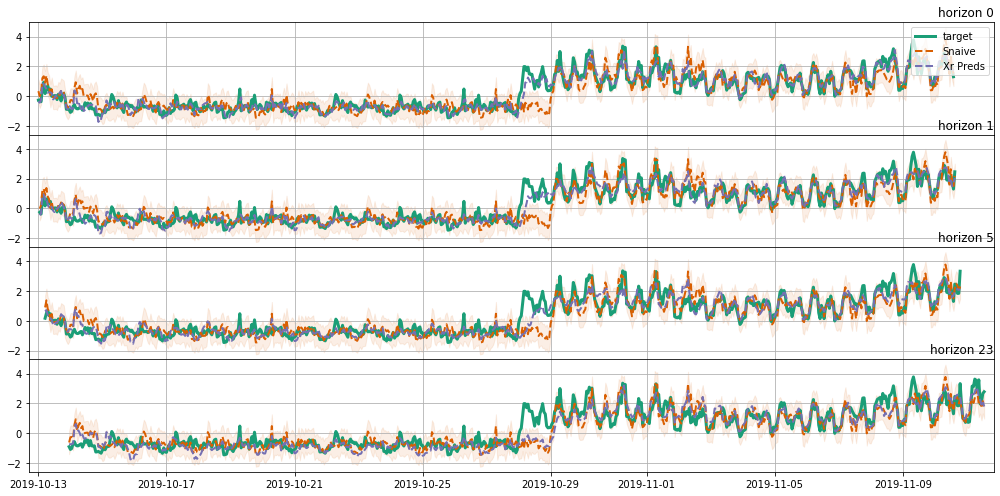

In [12]:
(TSMetrics(target, snaive, xr_preds)
.for_horizons(0, 1, 5, 23)
.for_time_slices(time_slices.all)
.with_description()
.with_metrics(mtx.MSE)
.with_predictions_plot()
.show())